In [67]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  
import math

In [140]:
def imhist(img):
    h, w = img.shape
    prob = np.zeros(shape=(256))
    
    for rv in img:
        for cv in rv:
            prob[int(cv)] += 1
            
    return prob
    

In [141]:
def rotate180(img):
    new_img = img.reshape(img.size)
    new_img = new_img[::-1]
    new_img = new_img.reshape(img.shape)
    return new_img

In [169]:
def reflectPadding(img, padding_size):
    h, w = img.shape
    p_h, p_w = padding_size
    new_img = np.zeros((h + 2*p_h, w + 2*p_w))
    new_img[p_h:p_h+h, p_w: p_w+w] = img
    new_img[0:p_h, 0:p_w] = rotate180(img[0:p_h, 0:p_w])
    new_img[0:p_h, p_w:p_w+w] = np.flipud(img[0:p_h, :])
    new_img[0:p_h, p_w+w:2*p_w+w] = rotate180(img[0:p_h, w-p_w:w])
    new_img[p_h:p_h+h, 0:p_w] = np.fliplr(img[:, 0:p_w])
    new_img[p_h+h:p_h*2+h, 0:p_w] = rotate180(img[h-p_h:h,0:p_w])
    new_img[p_h+h:p_h*2+h, p_w:p_w+w] = np.flipud(img[h-p_h:h, :])
    new_img[p_h+h:p_h*2+h, p_w+w:2*p_w+w] = rotate180(img[h-p_h:h, w-p_w:w])
    new_img[p_h:p_h+h, p_w+w:2*p_w+w] = np.fliplr(img[:, w-p_w:w])
    
    
    return new_img

In [224]:
def localhisteq(image, windowSize):
    p_h, p_w = math.floor(window_size[0]/2), math.floor(window_size[1]/2)
    #padded_img = reflectPadding(image, [p_h, p_w])
    padded_img = np.pad(image, [p_h, p_w], 'reflect')
    
    h, w = image.shape
    new_img = np.zeros(image.shape)
    for i in range(h):
        for j in range(w):
            center_pixel = padded_img[i+p_h, j+p_w]
            neighbors = padded_img[i:i+2*p_h, j:j+2*p_w]
            
            hist,_ = np.histogram(neighbors.flatten(),256,[0,255])
            hist_mask = hist.nonzero()
            cdf = hist.cumsum()
            cdf_nonzero = cdf[hist_mask]
            cdf_normalized = (cdf - cdf_nonzero[0]) / (cdf_nonzero[-1] - cdf_nonzero[0])
            new_center_pixel = 255 * cdf_normalized[int(center_pixel)]
            new_img[i, j] = new_center_pixel

    return new_img
    

 ## Local Histogram Equalization

In [ ]:

window_size = [21, 21]
img = cv2.imread("Lena.bmp")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray
origin_hist = imhist(gray)
localhisteq_img = localhisteq(gray, window_size)

<BarContainer object of 256 artists>

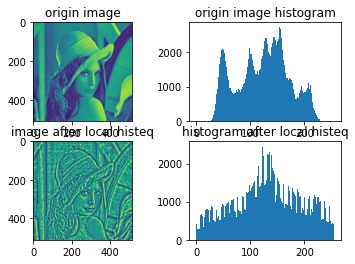

In [176]:
plt.figure('Local Histogram Equalization')
plt.subplot(2,2,1)
plt.title("origin image")
plt.imshow(gray)

plt.subplot(2,2,2)
plt.title("origin image histogram")
plt.bar([i for i in range(len(origin_hist))], origin_hist, width=1)


plt.subplot(2,2,3)
plt.title("image after local histeq")
#plt.imshow(cv2.cvtColor(localhisteq_img.astype('float32'), cv2.COLOR_GRAY2BGR))
plt.imshow(localhisteq_img)

localhisteq_img_hist = imhist(localhisteq_img)
plt.subplot(2,2,4)
plt.title("histogram after local histeq")
plt.bar([i for i in range(len(localhisteq_img_hist))], localhisteq_img_hist, width=1)


## Histogram Transfer

In [209]:
def histogram_pixel_transfer(x, hsrc, htgt, hsbins, htbins):
    count = (hsbins[1:-1] <= x).sum()
    ci = hsrc[count]
    cm = (htgt <= ci).sum()
    
    # choose endpoints if value is outside of target range
    # otherwise, choose average target bin value
    if (cm == 0):
        return htbins[0]
    elif (cm == len(htbins) - 1):
        return htbins[len(htbins) - 1]
    else:
        return (htbins[cm] + htbins[cm + 1])/2

def hist_transfer(source, target):    
    htgt, htbins = np.histogram(target.flatten(), 256, [0,255])
    hsrc, hsbins = np.histogram(source.flatten(), 256, [0,255])
    
    ctgt = np.cumsum(htgt)
    ctgt = ctgt / float(ctgt.max())
    
    csrc = np.cumsum(hsrc)
    csrc = csrc / float(csrc.max())

    result = np.empty(source.shape)
    jj = 0
    for ii in source.flat:
        result.flat[jj] = histogram_pixel_transfer(ii, csrc, ctgt, hsbins, htbins)
        jj+=1
        
    return result
    

<BarContainer object of 256 artists>

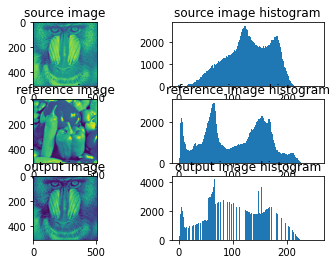

In [210]:
src_img = cv2.imread("Mandrill.bmp")
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
ref_img = cv2.imread("Peppers.bmp")
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
output_img = hist_transfer(src_img, ref_img)

plt.figure('Histogram Transfer')
plt.subplot(3,2,1)
plt.title("source image")
plt.imshow(src_img)

source_hist = imhist(src_img)
plt.subplot(3,2,2)
plt.title("source image histogram")
plt.bar([i for i in range(len(source_hist))], source_hist, width=1)


plt.subplot(3,2,3)
plt.title("reference image")
plt.imshow(ref_img)

ref_hist = imhist(ref_img)
plt.subplot(3,2,4)
plt.title("reference image histogram")
plt.bar([i for i in range(len(ref_hist))], ref_hist, width=1)

plt.subplot(3,2,5)
plt.title("output image")
plt.imshow(output_img)

output_hist = imhist(output_img)
plt.subplot(3,2,6)
plt.title("output image histogram")
plt.bar([i for i in range(len(output_hist))], output_hist, width=1)
